In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import torch
import torch.nn as nn
import numpy as np
from utilis_ForsaV2 import *
import utilis_ForsaV2
# !pip install fxpmath\
from fxpmath import Fxp
import time
word_size  = 8
frac_size = 6
utilis_ForsaV2.word_size = word_size
utilis_ForsaV2.frac_size = frac_size
# from tensorboardX import SummaryWriter
# from transforms import *


In [3]:
# from models_cust import *
model = torch.hub.load('pytorch/vision:v0.10.0', 'squeezenet1_0', pretrained=True)
model.eval()

Using cache found in C:\Users\huruy/.cache\torch\hub\pytorch_vision_v0.10.0


SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [4]:
# # Uncomment to visualize it in netron locally
# # Assuming `model` is your PyTorch model
# model_path = './PretrainedModels/squeezenet1_0PretrainedIM1K.pth'

# # # Save the entire model, including its architecture and trained parameters
# # # torch.save(model, model_path)
# torch.jit.script(model).save(model_path)

In [5]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

1248424


# Sorting first conv blocks

In [6]:
No_conv_layers=26 # to exlude classifier network
sw_wt = np.zeros(No_conv_layers)
sw_wt_sorted = np.zeros(No_conv_layers)


In [7]:
# Sorting features.0
_, new_indx1 = sortFullMatrix_V2(model.features[0].weight)
model.features[0].weight.data, _, sw_wt[0], sw_wt_sorted[0]  = compare_sw_sort(model.features[0].weight.data, new_indx1, -3, printsumm=True)
model.features[0].bias.data, _, _, _  = compare_sw_sort(model.features[0].bias.data, new_indx1, -1)
# Rearranging features.3.squeeze
model.features[3].squeeze.weight.data = model.features[3].squeeze.weight[:, new_indx1, :, :]

Switching before sorting 53762.0
Switching after sorting 43609.0
Percentage of switching reduction 18.885086120308024 %


In [8]:
# Sorting features.3.squeeze
_, new_indx1 = sortFullMatrix_V2(model.features[3].squeeze.weight)
model.features[3].squeeze.weight.data, _, sw_wt[1], sw_wt_sorted[1]  = compare_sw_sort(model.features[3].squeeze.weight.data, new_indx1, -3, printsumm=True)
model.features[3].squeeze.bias.data, _, _, _  = compare_sw_sort(model.features[3].squeeze.bias.data, new_indx1, -1)
# Rearranging features.3.expand1x1 and features.3.expand3x3
model.features[3].expand1x1.weight.data = model.features[3].expand1x1.weight[:, new_indx1, :, :]
model.features[3].expand3x3.weight.data = model.features[3].expand3x3.weight[:, new_indx1, :, :]

Switching before sorting 5532.0
Switching after sorting 5105.0
Percentage of switching reduction 7.718727404193782 %


In [9]:
features_lst = [3, 4, 5, 7, 8, 9, 10, 12]
iplus1 = 0
sw_wt_idx = 1
for i in features_lst:
    print('working on block ...', i)
    # Sorting features.3.squeeze
    _, new_indx1 = sortFullMatrix_V2(model.features[i].squeeze.weight)
    model.features[i].squeeze.weight.data, _, sw_wt[sw_wt_idx], sw_wt_sorted[sw_wt_idx]  = compare_sw_sort(model.features[i].squeeze.weight.data, new_indx1, -3, printsumm=True)
    sw_wt_idx = sw_wt_idx + 1
    model.features[i].squeeze.bias.data, _, _, _  = compare_sw_sort(model.features[i].squeeze.bias.data, new_indx1, -1)
    # Rearranging features.3.expand1x1 and features.3.expand3x3
    model.features[i].expand1x1.weight.data = model.features[i].expand1x1.weight[:, new_indx1, :, :]
    model.features[i].expand3x3.weight.data = model.features[i].expand3x3.weight[:, new_indx1, :, :]
    

    # Sorting features.3.expand1x1
    _, new_indxb1 = sortFullMatrix_V2(model.features[i].expand1x1.weight)
    model.features[i].expand1x1.weight.data, _, sw_wt[sw_wt_idx], sw_wt_sorted[sw_wt_idx]  = compare_sw_sort(model.features[i].expand1x1.weight.data, new_indxb1, -3, printsumm=True)
    sw_wt_idx = sw_wt_idx + 1
    model.features[i].expand1x1.bias.data, _, _, _  = compare_sw_sort(model.features[i].expand1x1.bias.data, new_indxb1, -1)
    # Sorting features.3.expand3x3
    _, new_indxb2 = sortFullMatrix_V2(model.features[i].expand3x3.weight)
    model.features[i].expand3x3.weight.data, _, sw_wt[sw_wt_idx], sw_wt_sorted[sw_wt_idx]  = compare_sw_sort(model.features[i].expand3x3.weight.data, new_indxb2, -3, printsumm=True)
    sw_wt_idx = sw_wt_idx + 1
    model.features[i].expand3x3.bias.data, _, _, _  = compare_sw_sort(model.features[i].expand3x3.bias.data, new_indxb2, -1)
    new_indxb2 = new_indxb2 + model.features[i].expand1x1.weight.shape[0] # incrementing all indeces  b2 for concatenation at the next layer
    new_indxsqz2 = np.concatenate((new_indxb1, new_indxb2), 0) #np.concatenate

    if i<=10:
        # Rearranging features.4.squeeze
        model.features[features_lst[iplus1+1]].squeeze.weight.data = model.features[features_lst[iplus1+1]].squeeze.weight[:, new_indxsqz2, :, :]
    else:
        # Rearranging classifier.1
        model.classifier[1].weight.data = model.classifier[1].weight[:, new_indxsqz2, :, :]
    iplus1 = iplus1 + 1

working on block ... 3
Switching before sorting 5105.0
Switching after sorting 5105.0
Percentage of switching reduction 0.0 %
Switching before sorting 3697.0
Switching after sorting 2683.0
Percentage of switching reduction 27.427644035704624 %
Switching before sorting 34905.0
Switching after sorting 29334.0
Percentage of switching reduction 15.960464116888698 %
working on block ... 4
Switching before sorting 7174.0
Switching after sorting 6680.0
Percentage of switching reduction 6.885977139671034 %
Switching before sorting 4033.0
Switching after sorting 2880.0
Percentage of switching reduction 28.58913959831391 %
Switching before sorting 34580.0
Switching after sorting 29902.0
Percentage of switching reduction 13.52805089647195 %
working on block ... 5
Switching before sorting 15985.0
Switching after sorting 13976.0
Percentage of switching reduction 12.56803253049734 %
Switching before sorting 15691.0
Switching after sorting 11557.0
Percentage of switching reduction 26.346313173156588 

In [10]:
print('Switching before sorting', sw_wt) 
print('Switching after sorting', sw_wt_sorted)
print('Percentage of reduction in switching in each fire modules', (sw_wt[:-1]-sw_wt_sorted[:-1])*100/sw_wt[:-1])
print('Percentage of reduction in switching across all inception modules', (np.sum(sw_wt[:-1], 0)-np.sum(sw_wt_sorted[:-1], 0))*100/np.sum(sw_wt[:-1], 0))

Switching before sorting [ 53762.   5105.   3697.  34905.   7174.   4033.  34580.  15985.  15691.
 139186.  30152.  15777. 139099.  46669.  34733. 209369.  67646.  35268.
 210644.  94453.  63988. 549790. 125252.  63924. 549310.      0.]
Switching after sorting [ 43609.   5105.   2683.  29334.   6680.   2880.  29902.  13976.  11557.
 123188.  28115.  11992. 120779.  41821.  25704. 180695.  62062.  26540.
 180916.  85259.  49018. 488981. 116780.  51188. 480412.      0.]
Percentage of reduction in switching in each fire modules [18.88508612  0.         27.42764404 15.96046412  6.88597714 28.5891396
 13.5280509  12.56803253 26.34631317 11.49397209  6.75577076 23.99061926
 13.1704757  10.38805203 25.99545101 13.69543724  8.2547379  24.74764659
 14.11291088  9.73394175 23.39501156 11.06040488  6.76396385 19.92365935
 12.54264441]
Percentage of reduction in switching across all inception modules 12.980042287012115


# Evaluating Model output 

In [11]:
# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms
filename = 'dog.jpg'
input_image = Image.open(filename)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)
# Tensor of shape 1000, with confidence scores over ImageNet's 1000 classes

# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)


In [12]:
# Read the categories
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]
# Show top categories per image
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())

Samoyed 0.9052743315696716
Arctic fox 0.016146525740623474
papillon 0.011715623550117016
West Highland white terrier 0.00972994789481163
Eskimo dog 0.009105916135013103


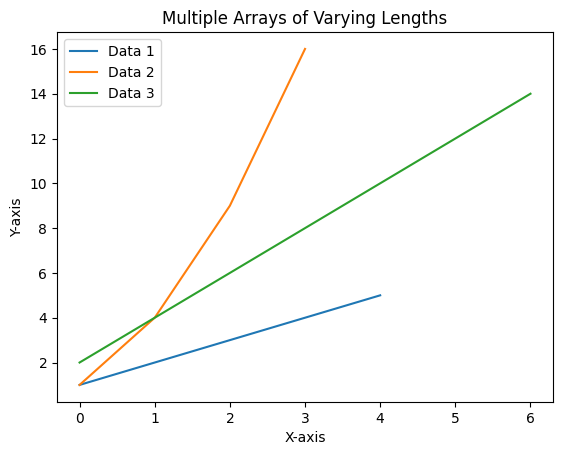

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data with varying lengths
data1 = np.array([1, 2, 3, 4, 5])
data2 = np.array([1, 4, 9, 16])
data3 = np.array([2, 4, 6, 8, 10, 12, 14])

# Find the maximum length among all arrays
max_len = max(len(data1), len(data2), len(data3))

# Pad the shorter arrays with None values to make them of equal length
data1 = np.append(data1, [None] * (max_len - len(data1)))
data2 = np.append(data2, [None] * (max_len - len(data2)))
data3 = np.append(data3, [None] * (max_len - len(data3)))

# Create a list of x values (assumes equally spaced data)
x_values = np.arange(max_len)

# Plot the data
plt.plot(x_values, data1, label='Data 1')
plt.plot(x_values, data2, label='Data 2')
plt.plot(x_values, data3, label='Data 3')

plt.legend()
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Multiple Arrays of Varying Lengths')
plt.show()
